In [1]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from snn_model import get_loss_fn
import torch
from torch.utils.data import TensorDataset, DataLoader
from snntorch import spikegen, surrogate
import matplotlib.pyplot as plt
from utils import load_dataset_df, fp_generator, smile_to_fp, data_splitter, get_spiking_net
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\knsve\Desktop\MEI\Tese\torch\snn_venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-geometri

In [1]:
#!pip install pandas numpy rdkit torch snntorch matplotlib scikit-learn deepchem pubchempy

Using legacy 'setup.py install' for pubchempy, since package 'wheel' is not installed.
    Running setup.py install for pubchempy: started
    Running setup.py install for pubchempy: finished with status 'done'


You should consider upgrading via the 'C:\Users\knsve\Desktop\MEI\Tese\torch\snn_venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
#https://github.com/chainer/chainer-chemistry/blob/master/chainer_chemistry/dataset/splitters/scaffold_splitter.py

#splitter = ScaffoldSplitter()
#tasks, datasets, transformers = dc.molnet.load_bbbp(splitter=splitter, featurizer="ECFP", reload=True)
#train, val, test = datasets

#### Load DataFrame

In [5]:
files = ['tox21.csv','sider.csv', 'BBBP.csv']
dt_file = files[1]
dirname = dt_file.strip('.csv')

df, targets = load_dataset_df(filename=dt_file)

for t in targets:
    df_temp = df[[t, 'smiles']].dropna()
    class_counts = df[t].count()
    class_sum = df[t].sum()
    print(t, class_counts, round(class_sum/class_counts, 2)) 


Hepatobiliary disorders 1427 0.52
Metabolism and nutrition disorders 1427 0.7
Product issues 1427 0.02
Eye disorders 1427 0.61
Investigations 1427 0.81
Musculoskeletal and connective tissue disorders 1427 0.7
Gastrointestinal disorders 1427 0.91
Social circumstances 1427 0.18
Immune system disorders 1427 0.72
Reproductive system and breast disorders 1427 0.51
Neoplasms benign, malignant and unspecified (incl cysts and polyps) 1427 0.26
General disorders and administration site conditions 1427 0.91
Endocrine disorders 1427 0.23
Surgical and medical procedures 1427 0.15
Vascular disorders 1427 0.78
Blood and lymphatic system disorders 1427 0.62
Skin and subcutaneous tissue disorders 1427 0.92
Congenital, familial and genetic disorders 1427 0.18
Infections and infestations 1427 0.7
Respiratory, thoracic and mediastinal disorders 1427 0.74
Psychiatric disorders 1427 0.71
Renal and urinary disorders 1427 0.64
Pregnancy, puerperium and perinatal conditions 1427 0.09
Ear and labyrinth disorde

In [21]:
if dirname == 'tox21':
    # SR-ARE
    target_name = targets[0]
elif dirname == 'sider':
    #Hepatobiliary disorders 1427 samples, 0.52 class ratio
    target_name = targets[0]
else:
    target_name = targets[0]
    
df = df[[target_name, 'smiles']].dropna()

#### SMILE to Fingerprint

In [22]:
fp_types = [['morgan', 1024], ['maccs', 167], ['RDKit', 1024], ['pubchem', 881]]
fp_type, num_bits = fp_types[1]
#num_bits = 512
fp_config = {"fp_type": fp_type,
             "num_bits": num_bits}
#num_bits = 237
print(fp_type, '-', num_bits)

maccs - 167


In [23]:
dtype = torch.float32
split = "scaffold"
dataset = None
if dirname != 'BBBP':
    split = "random"
    fp_array, target_array = smile_to_fp(df, fp_config=fp_config, target_name=target_name)
    # Create Torch Dataset
    fp_tensor = torch.tensor(fp_array, dtype=dtype)
    target_tensor = torch.tensor(target_array, dtype=dtype).long()

    dataset = TensorDataset(fp_tensor, target_tensor)

#### Loss Function

In [24]:
from sklearn.utils.class_weight import compute_class_weight

loss_types = ['cross_entropy', 'rate_loss', 'temporal_loss']
loss_type = loss_types[0]
print(loss_type)


cross_entropy


#### Train Loop

In [25]:
net_types = ["SNN", "DSNN", "CSNN"]
net_type = net_types[0]
#spike_grad = surrogate.sigmoid(slope=25)
spike_grad = None
net_config = {"input_size": num_bits,
              "num_hidden": 512,
              "time_steps": 10,
              "spike_grad": spike_grad
              }

fast sigmoid / sigmoid
lr = 1e-5 ou -6, com 500-1000 epochs
batch size 16
batches devem incluir pos e neg samples
Adamax

experimentar com Tox21 NR-AR
temporal coding se não aumentar com rate coding

ver oversampling 

In [38]:
lr=1e-5 #default was e5-5
iterations = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 32
train_config = {"num_epochs": 500,
                "batch_size": batch_size,
                "device": device,
                "loss_type": loss_type,
                "loss_fn": None,
                'dtype': dtype,
                'num_steps': net_config['time_steps'],
                'val_net': None
                }
results = [[], [], [], [], [], []]

cpu


In [28]:
from rdkit import RDLogger

# Disable RDKit logging
RDLogger.DisableLog('rdApp.*')


In [40]:
for iter in range(iterations):
    print(f"Iteration:{iter + 1}/{iterations}")
    random.seed(iter+1)

    net, train_net, val_net, test_net = get_spiking_net(net_type, net_config)
    net = net.to(device)
    train_config['val_net'] = val_net
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0)
    #experimentar weight decay = 1e-4 e subir (pouco, 1e-3)

    # DATA SPLIT
    train, val, test = data_splitter(df, target_name, split=split, dataset=dataset, fp_config=fp_config, seed=iter+1, dtype=dtype)
    _, train_label = train[:]
    _, val_label = val[:]
    _, test_label = test[:]
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

    # LOSS FN
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=np.array(train_label))
    #class_weights[0] = class_weights[0]/2 
    #class_weights[0] = class_weights[0]*2
    class_weights = torch.tensor(class_weights, dtype=torch.float)
    #class_weights = None
    train_config["loss_fn"] = get_loss_fn(loss_type=loss_type, class_weights=class_weights)

    # TRAINING
    net, loss_hist, val_acc_hist, val_auc_hist = train_net(net=net, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, train_config=train_config)

    # TESTING
    all_preds, all_targets = test_net(net, device, test_loader)
    print(len(test_loader))
    # METRICS
    accuracy = accuracy_score(all_targets, all_preds)
    auc_roc = roc_auc_score(all_targets, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)

    results[0].append(accuracy)
    results[1].append(auc_roc)
    results[2].append(sensitivity)
    results[3].append(specificity)
    results[4].append(f1)
    results[5].append(precision)


Iteration:1/1
Epoch:1


C:\Users\knsve\AppData\Local\Temp\ipykernel_11308\658590698.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=np.array(train_label))


Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9
Epoch:10
Epoch:11
Epoch:12
Epoch:13
Epoch:14
Epoch:15
Epoch:16
Epoch:17
Epoch:18
Epoch:19
Epoch:20
Epoch:21
Epoch:22
Epoch:23
Epoch:24
Epoch:25
Epoch:26
Epoch:27
Epoch:28
Epoch:29
Epoch:30
Epoch:31
Epoch:32
Epoch:33
Epoch:34
Epoch:35
Epoch:36
Epoch:37
Epoch:38
Epoch:39
Epoch:40
Epoch:41
Epoch:42
Epoch:43
Epoch:44
Epoch:45
Epoch:46
Epoch:47
Epoch:48
Epoch:49
Epoch:50
Epoch:51
Epoch:52
Epoch:53
Epoch:54
Epoch:55
Epoch:56
Epoch:57
Epoch:58
Epoch:59
Epoch:60
Epoch:61
Epoch:62
Epoch:63
Epoch:64
Epoch:65
Epoch:66
Epoch:67
Epoch:68
Epoch:69
Epoch:70
Epoch:71
Epoch:72
Epoch:73
Epoch:74
Epoch:75
Epoch:76
Epoch:77
Epoch:78
Epoch:79
Epoch:80
Epoch:81
Epoch:82
Epoch:83
Epoch:84
Epoch:85
Epoch:86
Epoch:87
Epoch:88
Epoch:89
Epoch:90
Epoch:91
Epoch:92
Epoch:93
Epoch:94
Epoch:95
Epoch:96
Epoch:97
Epoch:98
Epoch:99
Epoch:100
Epoch:101
Epoch:102
Epoch:103
Epoch:104
Epoch:105
Epoch:106
Epoch:107
Epoch:108
Epoch:109
Epoch:110
Epoch:111
Epoch:

In [37]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=np.array(train_label))
class_weights[0] = class_weights[0]/2 
class_weights[1] = class_weights[1]*2
print(class_weights)

[0.29740939 6.27321669]


C:\Users\knsve\AppData\Local\Temp\ipykernel_11308\484247568.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=np.array(train_label))


#### Smoothed Loss

[2.175330638885498, 1.9115872383117676, 1.9480377435684204, 3.175977945327759, 2.7778024673461914]


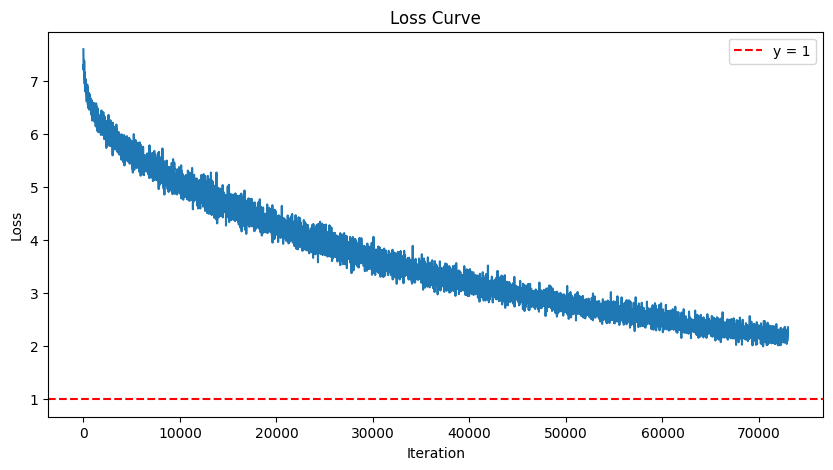

In [32]:
#from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
#from statsmodels.nonparametric.smoothers_lowess import lowess

print(loss_hist[len(loss_hist) - 5:len(loss_hist)])

fig = plt.figure(facecolor="w", figsize=(10, 5))
#plt.plot(np.convolve(loss_hist, np.ones(30)/30, mode='valid'))
#plt.plot(savgol_filter(loss_hist, window_length=100, polyorder=3))
#plt.plot(lowess(loss_hist, np.arange(len(loss_hist)), frac=0.1)[:, 1])
plt.plot(gaussian_filter1d(loss_hist, sigma=6))
#plt.plot(loss_hist)
plt.axhline(y=1, color='r', linestyle='--', label='y = 1')
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
# Validation Set
fig = plt.figure(facecolor="w", figsize=(10, 5))

plt.plot(gaussian_filter1d(val_auc_hist, sigma=6))
#plt.plot(val_auc_hist)
plt.axhline(y=1, color='r', linestyle='--', label='y = 1')
plt.title("ROC AUC every 5 epochs.")
plt.xlabel("Iteration")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()

#### Save Metrics

In [33]:
metrics_np = np.zeros(12)

for i, metric in enumerate(results):
    metrics_np[i*2] = np.round(np.mean(metric), 3)
    metrics_np[i*2+1] = np.round(np.std(metric), 3)

# Print Results
print(f"Accuracy:  {metrics_np[0]:.3f} ± {metrics_np[1]:.3f}")
print(f"AUC ROC: {metrics_np[2]:.3f} ± {metrics_np[3]:.3f}")
print(f"Sensitivity: {metrics_np[4]:.3f} ± {metrics_np[5]:.3f}")
print(f"Specificity: {metrics_np[6]:.3f} ± {metrics_np[7]:.3f}")

metric_names = ['Acc', 'AUC', 'Sn', 'Sp', 'F1', 'Precision']
metrics_np = metrics_np.reshape(1, -1)
columns = []
for name in metric_names:
    columns.extend([f'Mean {name}', f'Std {name}'])


df_metrics = pd.DataFrame(metrics_np, columns=columns)
num_hidden = net_config['num_hidden']
time_steps = train_config['num_steps']
num_epochs = train_config['num_epochs']

if dirname == 'BBBP':
    if net_type == 'CSNN':
        filename = f"results\\{dirname}\\{net_type}_{fp_type}_{num_bits}_{time_steps}_lr{lr}_e{num_epochs}_{loss_type}_{split}.csv"
    else:
        filename = f"results\\{dirname}\\{net_type}_{fp_type}_{num_bits}_{num_hidden}_{time_steps}_lr{lr}_e{num_epochs}_{loss_type}_{split}.csv"
else:
    filename = f"results\\{dirname}\\{target_name}_{net_type}_{fp_type}_{num_bits}_{num_hidden}_{time_steps}_lr{lr}_e{num_epochs}_{loss_type}_{split}.csv"


df_metrics.to_csv(filename, index=False)

print(filename)

Accuracy:  0.832 ± 0.000
AUC ROC: 0.656 ± 0.000
Sensitivity: 0.386 ± 0.000
Specificity: 0.925 ± 0.000
results\tox21\SR-ARE_SNN_maccs_167_512_10_lr1e-05_e500_cross_entropy_random.csv


In [16]:
#from torchsummary import summary
#summary(net, input_size=(1, 1024),  batch_size=32)

#from torchinfo import summary

#summary(net, input_size=(batch_size, 1, 1024), verbose=0)